### Time Series modeling with shortlist Zipcodes

In [1]:
%load_ext autoreload
%autoreload 2

Necessary imports

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from src import cleaning_functions as cfs

Loading csv narrowing down to zipcodes in Chicago Metropolitan area.

In [5]:
df = cfs.load_df()

In [6]:
melted_df = cfs.melt_data(df)

In [7]:
chicago_df = df[(df['Metro'] == 'Chicago') & (df['State'] == 'IL')]

For now we are relying on Return On Investments in the past 5 and 2 year periods (current year = 2018)

May include more zipcodes based on market research later

In [8]:
chicago_df['ROI_5yrs'] = ((chicago_df['2018-04'] - chicago_df['2013-04'])/chicago_df['2013-04'])*100
chicago_df['ROI_2yrs'] = ((chicago_df['2018-04'] - chicago_df['2016-04'])/chicago_df['2016-04'])*100

Top 30 zipcodes based on ROI 

In [9]:
top_30 = chicago_df.sort_values('ROI_5yrs', ascending=False)[:100].sort_values('ROI_2yrs', ascending=False)[:30].RegionName

Team decided to split these zipcodes to analyze them more closely

working with 20 through 30 

In [10]:
top_30[20:].values

array([60447, 60155, 60164, 60435, 60411, 60139, 60178, 60104, 60185,
       60097])

In [11]:
chicago_20_30 = pd.DataFrame()
chicago_20_30['time'] = pd.date_range(start='1996-04-01', end='2018-04-01', freq='MS')
chicago_20_30.set_index('time', inplace=True)
for region in top_30[20:].values:
    chicago_20_30[region] = melted_df[melted_df['RegionName'] == region].value.values

In [12]:
chicago_20_30.head()

,60447,60155,60164,60435,60411,60139,60178,60104,60185,60097
time,,,,,,,,,,
1996-04-01,135400.0,108900.0,124400.0,95800.0,81900.0,128200.0,153900.0,97900.0,147300.0,110400.0
1996-05-01,135800.0,108500.0,124700.0,95900.0,82500.0,128200.0,154000.0,98300.0,147400.0,110800.0
1996-06-01,136300.0,108100.0,124700.0,96000.0,82900.0,128200.0,154100.0,98600.0,147500.0,111100.0
1996-07-01,136800.0,107600.0,124400.0,96000.0,83000.0,128200.0,154100.0,98700.0,147800.0,111400.0
1996-08-01,137500.0,107200.0,123900.0,96100.0,82800.0,128200.0,154100.0,98500.0,148100.0,111700.0


In [15]:
chicago_20_30.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', length=265, freq=None)

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima

In [14]:
#! pip install pmdarima

In [15]:
chicago_20_30.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', length=265, freq=None)

### Note:
With our time series experiencing irregular trend during the housing bubble and market crash around 2008 where home values dropped significantly over the few years following the crash and since such irregular cycles are not ideal to work with, we'll try building two different models where:
- one accounts for all the years from 1996 through 2018 
- the other that avoids the recession years and trains only after the market was on route to recover (starting 2012 -2013)

#### Train Test Split

In [16]:
#train test split ~ 90:10
chicago_train_all = chicago_20_30.loc[:'2016-01-01', :]
chicago_test_all = chicago_20_30.loc['2016-02-01':, :]

In [17]:
chicago_train = chicago_20_30.loc['2013-04-01':'2017-10-01',:]
chicago_test = chicago_20_30.loc['2017-11-01':,:]

In [18]:
len(chicago_train_all) + len(chicago_test_all) == 265

True

In [19]:
len(chicago_train) + len(chicago_test) == 61

True

In [20]:
chicago_train_all.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
               '2015-12-01', '2016-01-01'],
              dtype='datetime64[ns]', name='time', length=238, freq=None)

In [21]:
chi_60447_all = chicago_train_all.iloc[:, 0]

In [22]:
rw_60447_all = ARIMA(chi_60447_all.values, (0,1,0)).fit()
y_hat_60447_all = rw_60447_all.predict(typ='levels')

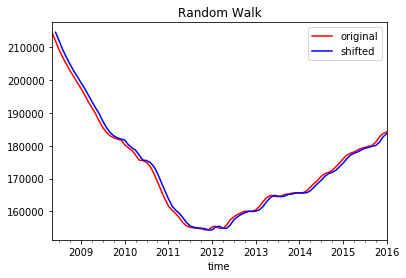

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

chi_60447_all[145:].plot(ax=ax, c='r', label='original')
chi_60447_all.shift(1).dropna()[145:].plot(ax=ax, c='b', label='shifted')
ax.set_title('Random Walk')
ax.legend();

In [24]:
rw_60447_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  237
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2007.146
Method:                           css   S.D. of innovations           1152.893
Date:                Tue, 28 Jul 2020   AIC                           4018.291
Time:                        14:13:53   BIC                           4025.227
Sample:                             1   HQIC                          4021.087
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        205.9072     74.888      2.750      0.006      59.128     352.686
==============================================================================
"""

In [25]:
ar_1_60447_all = ARIMA(chi_60447_all.values, (1,0,0)).fit()
ar_1_60447_all.aic

4052.4482071220955

In [26]:
am_1_60447_all = ARIMA(chi_60447_all.values, (0,0,1)).fit()
am_1_60447_all.aic

5215.800077515262

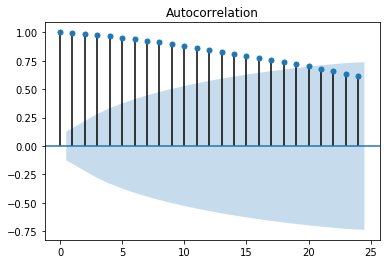

In [27]:
plot_acf(chi_60447_all);

When Looking at the ACF graph for the original data, we see a strong persistent correlation with higher order lags. This is evidence that we should take a **first difference** of the data to remove this autocorrelation.

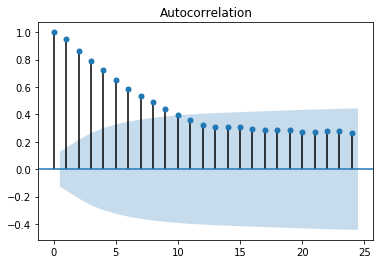

In [28]:
plot_acf(chi_60447_all.diff().dropna());

Generally, we use an ACF to predict MA terms.
Moving Average models are using the error terms of the predicitons to calculate the next value.  This means that the algorithm does not incorporate the direct effect of the previous value. It models what are sometimes called **impulses** or **shocks** whose effect takes into accounts for the propogation of correlation from one lag to the other. 

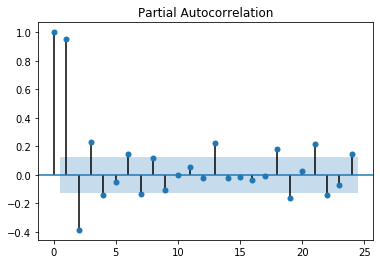

In [29]:
plot_pacf(chi_60447_all.diff().dropna());

The shaded area of the graph is the confidence interval.  When the correlation drops into the shaded area, that means there is no longer statistically significant correlation between lags.
Some rules of thumb: 

    - A sharp drop after lag "k" suggests an AR-K model.
    - A gradual decline suggests an MA.

### Trimmed Time Series 
2013 onwards

In [30]:
chi_60447 = chicago_train.iloc[:, 0]

In [66]:
chi_60447.values

array([164200., 164900., 164700., 164500., 164700., 165200., 165300.,
       165600., 165700., 165600., 165700., 166300., 167400., 168500.,
       169500., 170700., 171500., 171900., 172500., 173600., 174700.,
       176000., 177100., 177700., 178100., 178700., 179200., 179500.,
       179800., 180100., 181100., 182700., 183700., 184200., 184200.,
       184700., 186200., 188200., 189600., 190900., 191800., 192500.,
       193400., 194300., 195000., 196300., 197600., 198800., 199900.,
       200800., 201600., 203200., 205300., 207600., 209700.])

In [31]:
rw_60447 = ARIMA(chi_60447.values, (0,1,0)).fit()
rw_60447.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   54
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -420.384
Method:                           css   S.D. of innovations            581.697
Date:                Tue, 28 Jul 2020   AIC                            844.768
Time:                        14:13:55   BIC                            848.746
Sample:                             1   HQIC                           846.302
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        842.5926     79.159     10.644      0.000     687.444     997.741
==============================================================================
"""

In [32]:
rw_60447.aic

844.7678736662609

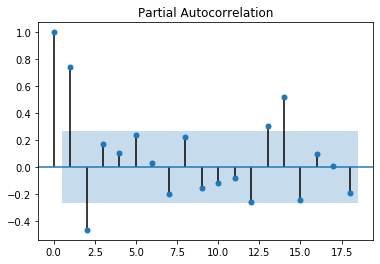

In [33]:
plot_pacf(chi_60447.diff().dropna());

indicates 1 AR term atleast!

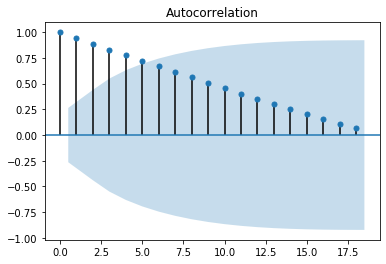

In [34]:
plot_acf(chi_60447);

differencing can help!

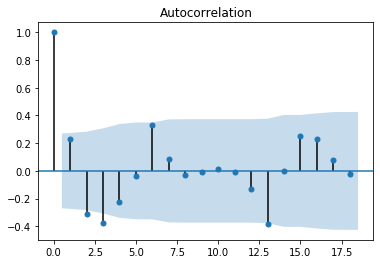

In [35]:
plot_acf(chi_60447.diff().diff().dropna());

No idication of MA term 

In [36]:
ar_1_60447 = ARIMA(chi_60447.values, (1,1,0)).fit()
ar_1_60447.aic

800.2593846120147

that's an improvement

In [37]:
arma_1_60447 = ARIMA(chi_60447.values, (1,1,1)).fit()
arma_1_60447.aic

790.6573250579041

In [38]:
ar_2_60447 = ARIMA(chi_60447.values, (2,1,0)).fit()
ar_2_60447.aic

790.2387879835067

In [39]:
auto_arima(chi_60447.values, start_p=0, start_q=0,
           max_p=6, max_q=6, seasonal=False,
           trace=True)

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=787.872, BIC=791.812, Time=0.014 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=782.567, BIC=788.478, Time=0.029 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=782.622, BIC=788.533, Time=0.027 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=786.110, BIC=788.080, Time=0.012 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=785.061, BIC=792.942, Time=0.035 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=784.632, BIC=792.513, Time=0.122 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=785.415, BIC=795.266, Time=0.209 seconds
Total fit time: 0.458 seconds


ARIMA(order=(1, 2, 0))

In [103]:
chi_60447.index

DatetimeIndex(['2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
               '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
               '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01'],
              dtype

In [129]:
ar1_d2 = ARIMA(reg1_train, (1,2,0)).fit()
ar1_d2.aic

815.4431605470666

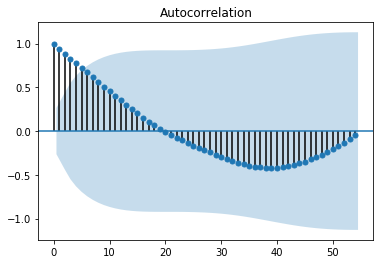

In [41]:
plot_acf(chi_60447, lags=54);

Checking for seasonality, don't really see one.

validating model on test set

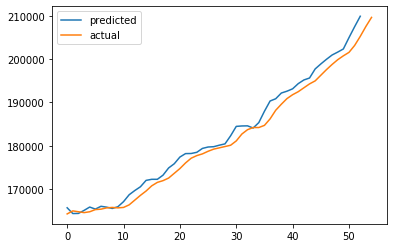

In [42]:
y_hat_train = ar1_d2.predict(typ='levels')

fig,ax = plt.subplots()
ax.plot(y_hat_train, label='predicted')
ax.plot(chi_60447.values, label='actual')
plt.legend();

In [44]:
chi_60447_test = chicago_test.iloc[:, 0]

In [45]:
chi_60447_test = pd.Series(chi_60447_test)

In [61]:
chi_60447_test.index

DatetimeIndex(['2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', freq=None)

In [69]:
print(chi_60447_test.index[0])
chi_60447_test.index[-1]

2017-11-01 00:00:00


Timestamp('2018-04-01 00:00:00')

In [94]:
chi_60447.index

DatetimeIndex(['2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
               '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
               '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01'],
              dtype

In [93]:
chi_60447_test['2017-11-01']

212100.0

In [104]:
chi_60447.index[:3]

DatetimeIndex(['2013-04-01', '2013-05-01', '2013-06-01'], dtype='datetime64[ns]', name='time', freq=None)

In [105]:
chi_60447.shape

(55,)

In [117]:
reg1 = df[df['RegionName'] == 60477]

In [119]:
def melt2_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City',
                                  'State', 'Metro', 'CountyName', 'RegionID', 'SizeRank'],
                     var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [120]:
melted_reg1 = melt2_data(reg1)

In [122]:
melted_reg1.set_index('time', inplace=True)

In [123]:
melted_reg1 = melted_reg1['value']

In [124]:
reg1_train = melted_reg1['2013-04-01': '2017-10-01']
reg1_test = melted_reg1['2017-11-01':]

In [130]:
ar1_d2.predict(start=reg1_test.index[0],
               end=reg1_test.index[-1],
               typ='levels')


2017-11-01    208064.390965
2017-12-01    209423.571859
2018-01-01    210823.838378
2018-02-01    212248.185010
2018-03-01    213691.226946
2018-04-01    215151.259082
Freq: MS, dtype: float64

In [108]:
len(chi_60447) + len(chi_60447_test)

61

In [67]:
ar1_d2.predict(start=chi_60447_test.index[0],
               end=chi_60447_test.index[-1],
               typ='levels', dynamic=True)

KeyError: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'

In [75]:
results = ar1_d2.forecast(steps=6)

In [81]:
results[0]

array([211764.04067477, 213833.39749983, 215918.45609987, 218021.82967795,
       220144.17576126, 222285.65979502])

In [ ]:
ar1_d2.plot_predict()

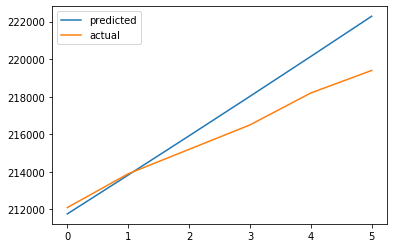

In [82]:
fig,ax = plt.subplots()
ax.plot(results[0], label='predicted')
ax.plot(chi_60447_test.values, label='actual')
plt.legend();

<Figure size 432x288 with 0 Axes>

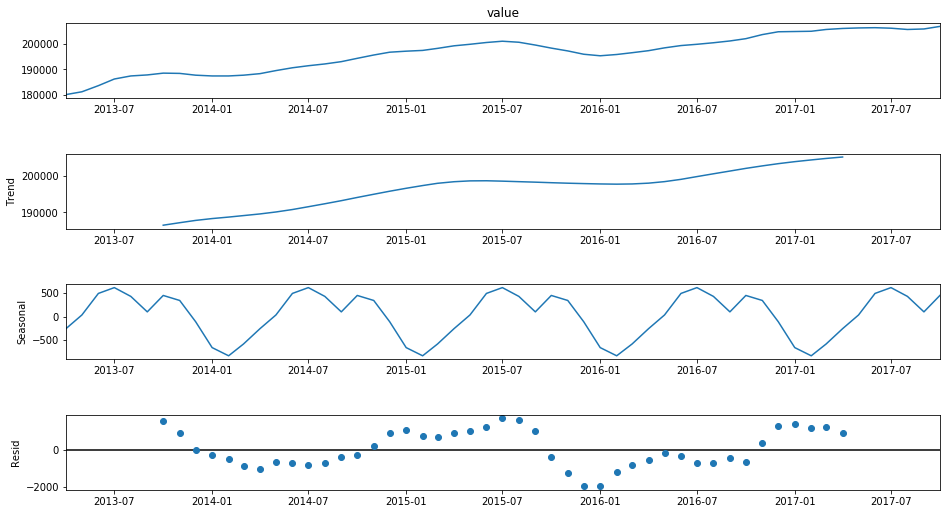

In [133]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(reg1_train)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [83]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
p = q = range(0, 2)
pdq = list(itertools.product(p, [2], q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =SARIMAX(chi_60447,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('hello')
            continue

Examples of parameter for SARIMA...
SARIMAX: (0, 2, 0) x (0, 1, 0, 12)
SARIMAX: (0, 2, 0) x (0, 1, 1, 12)
SARIMAX: (0, 2, 0) x (1, 1, 0, 12)
SARIMAX: (0, 2, 0) x (1, 1, 1, 12)
SARIMAX: (0, 2, 1) x (0, 1, 0, 12)
SARIMAX: (0, 2, 1) x (0, 1, 1, 12)
SARIMAX: (0, 2, 1) x (1, 1, 0, 12)
SARIMAX: (0, 2, 1) x (1, 1, 1, 12)
SARIMAX: (1, 2, 0) x (0, 1, 0, 12)
SARIMAX: (1, 2, 0) x (0, 1, 1, 12)
SARIMAX: (1, 2, 0) x (1, 1, 0, 12)
SARIMAX: (1, 2, 0) x (1, 1, 1, 12)
SARIMAX: (1, 2, 1) x (0, 1, 0, 12)
SARIMAX: (1, 2, 1) x (0, 1, 1, 12)
SARIMAX: (1, 2, 1) x (1, 1, 0, 12)
SARIMAX: (1, 2, 1) x (1, 1, 1, 12)
ARIMA(0, 2, 0)x(0, 1, 0, 12) - AIC:627.985245207784
ARIMA(0, 2, 0)x(0, 1, 1, 12) - AIC:1212.1770606877794
ARIMA(0, 2, 0)x(1, 1, 0, 12) - AIC:442.28090586531346
ARIMA(0, 2, 0)x(1, 1, 1, 12) - AIC:1279.4597196746165
ARIMA(0, 2, 1)x(0, 1, 0, 12) - AIC:609.1755554463319
ARIMA(0, 2, 1)x(0, 1, 1, 12) - AIC:1078.9787553423146
ARIMA(0, 2, 1)x(1, 1, 0, 12) - AIC:441.98491990257907
ARIMA(0, 2, 1)x(1, 1, 1, 12) 

In [84]:
sari_mod =SARIMAX(chi_60447,order=(1,2,0),seasonal_order=(1,1,0,12),
                  enforce_stationarity=False,enforce_invertibility=False).fit()


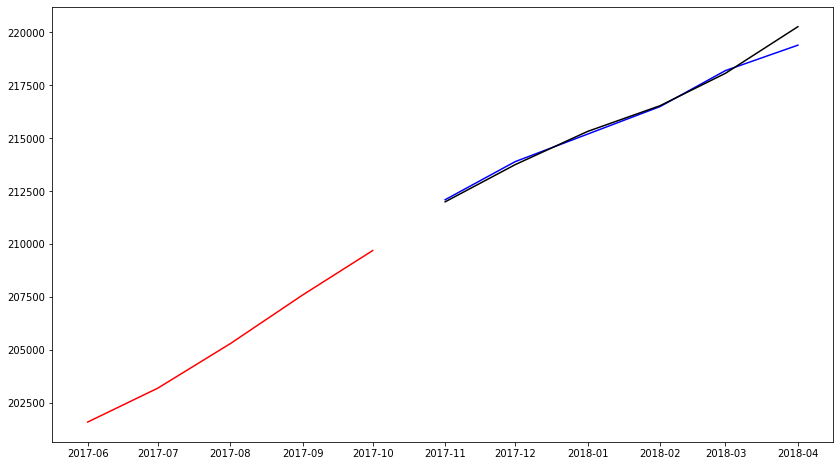

In [141]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=chi_60447_test.index[0],
                              end=chi_60447_test.index[-1],typ='levels')

fig, ax = plt.subplots(figsize=(14,8))
ax.plot(chi_60447[50:], color='r')
ax.plot(chi_60447_test, color='b')

ax.plot(y_hat_test, color='k');